## Metrics (Training Results)

This notebook shows the training results of different models, including CNN and Particle Transformer. Most of the training results are repeated 5 times with different random seeds.

The signal and background were set to be Higgs from VBF and GGF, respectively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns

sns.set_theme()

# Define the root of the project
project_root = Path.cwd().parent

def get_metrics(channel: str, data_mode: str, date_time: str, data_suffix: str = '', information: str = '', verbose: bool = True, num_rnd: int = None):
    """Print summary metrics for different models under given configuration."""

    # Print header
    if verbose:
        info_suffix = f" ({information})" if information else ""
        print(f"# Metrics for {channel}/{data_mode} at {date_time}{info_suffix}")

    # Define path to metrics output
    output_dir = project_root / 'output' / channel / data_mode

    # Loop through models
    metrics = {}
    for model in ['CNN_EventCNN', 'ParT_Light']:

        # Collect metrics from each random seed run
        tmp_metrics = []
        rnd_seed = 23

        for _ in range(num_rnd):
            metrics_file = output_dir / f"{model}-{date_time}-{data_suffix}" / f'rnd_seed-{rnd_seed}' / 'metrics.csv'
            if not metrics_file.exists():
                break

            df_tmp = pd.read_csv(metrics_file)
            tmp_metrics.append(df_tmp.tail(1))  # Use the last row (test result)
            rnd_seed += 100

        # Print summary statistics if any runs were found
        if tmp_metrics:
            df = pd.concat(tmp_metrics, ignore_index=True)
            acc_mean, acc_std = df['test_accuracy'].mean(), df['test_accuracy'].std()
            auc_mean, auc_std = df['test_auc'].mean(), df['test_auc'].std()
            epoch_mean, epoch_std = df['epoch'].mean(), df['epoch'].std()

            if verbose:
                print(f"{model:<15} ({len(tmp_metrics)} runs): "
                      f"ACC {acc_mean:.3f} ± {acc_std:.3f} | "
                      f"AUC {auc_mean:.3f} ± {auc_std:.3f} | "
                      f"Epochs {epoch_mean:.1f} ± {epoch_std:.1f}")
            
            metrics[model] = {'acc_mean': acc_mean, 'acc_std': acc_std, 'auc_mean': auc_mean, 'auc_std': auc_std}

    if verbose:
        print('\n' + '-' * 80 + '\n')

    return metrics

## $H \rightarrow \gamma \gamma$

### >>> Keras-like settings

- Keras parameter initialization
- Keras batch normanlizaiton in CNN

# Metrics for diphoton/jet_flavor at 20250906_135600
CNN_EventCNN    (10 runs): ACC 0.600 ± 0.020 | AUC 0.639 ± 0.028 | Epochs 70.0 ± 19.0

--------------------------------------------------------------------------------

# Metrics for diphoton/jet_flavor at 20250906_135600
CNN_EventCNN    (10 runs): ACC 0.644 ± 0.008 | AUC 0.695 ± 0.011 | Epochs 65.3 ± 7.9

--------------------------------------------------------------------------------

# Metrics for diphoton/jet_flavor at 20250906_135600
CNN_EventCNN    (10 runs): ACC 0.667 ± 0.006 | AUC 0.727 ± 0.007 | Epochs 55.1 ± 14.7

--------------------------------------------------------------------------------

# Metrics for diphoton/jet_flavor at 20250906_135600
CNN_EventCNN    (10 runs): ACC 0.673 ± 0.006 | AUC 0.735 ± 0.006 | Epochs 60.0 ± 5.2

--------------------------------------------------------------------------------

# Metrics for diphoton/jet_flavor at 20250906_135600
CNN_EventCNN    (10 runs): ACC 0.672 ± 0.006 | AUC 0.732 ± 0.

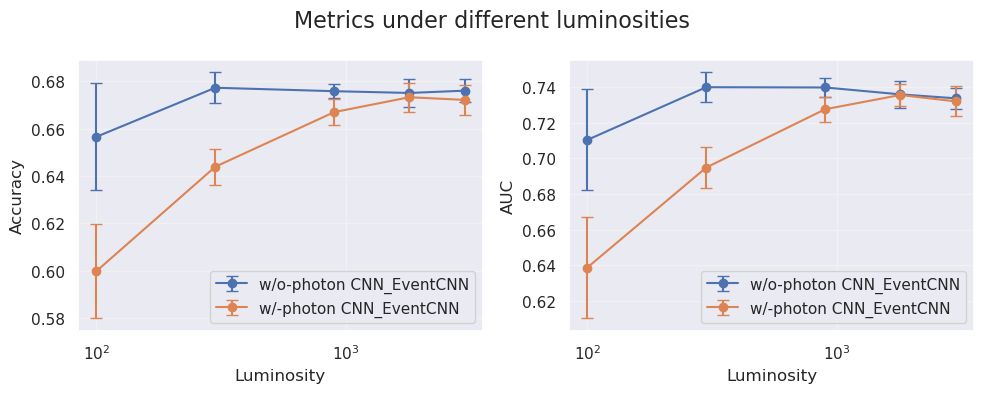

In [2]:
luminosities = [100, 300, 900, 1800, 3000]
in_metrics = []
ex_metrics = []

for data_mode in ['jet_flavor']:
    for L in luminosities:
        in_metrics.append(get_metrics(channel='diphoton', data_mode=data_mode, date_time='20250906_135600', data_suffix=f'L{L}', verbose=True, num_rnd=10))
        ex_metrics.append(get_metrics(channel='ex-diphoton', data_mode=data_mode, date_time='20250906_135600', data_suffix=f'L{L}', verbose=False, num_rnd=10))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f"Metrics under different luminosities", fontsize=16)
for model in ['CNN_EventCNN']:
# for model in ['CNN_EventCNN', 'ParT_Light']:
    ax[0].errorbar(luminosities, [m[model]['acc_mean'] for m in ex_metrics if m], yerr=[m[model]['acc_std'] for m in ex_metrics if m], marker='o', capsize=4, label=f"w/o-photon {model}")
    ax[1].errorbar(luminosities, [m[model]['auc_mean'] for m in ex_metrics if m], yerr=[m[model]['auc_std'] for m in ex_metrics if m], marker='o', capsize=4, label=f"w/o-photon {model}")
    ax[0].errorbar(luminosities, [m[model]['acc_mean'] for m in in_metrics if m], yerr=[m[model]['acc_std'] for m in in_metrics if m], marker='o', capsize=4, label=f"w/-photon {model}")
    ax[1].errorbar(luminosities, [m[model]['auc_mean'] for m in in_metrics if m], yerr=[m[model]['auc_std'] for m in in_metrics if m], marker='o', capsize=4, label=f"w/-photon {model}")

for i, ylabel in enumerate(['Accuracy', 'AUC']):
    ax[i].set_xscale("log")
    ax[i].set(xlabel="Luminosity", ylabel=ylabel)
    ax[i].legend()
    ax[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()